# Armenia Data Setup

In [1]:
# --- System and file handling ---
import os
import pandas as pd
import imageio

# --- Numerical and array operations ---
import numpy as np

# --- Raster handling ---
import rasterio
from rasterio.plot import show
from rasterio.windows import from_bounds

# --- Geo-spatial handling ---
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# --- Plotting ---
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import cm

In [2]:
# --- Path to SPEI raster data ---
data_dir = 'SPEI_Data'

# --- Find all folders starting with 'sem01' ---
folders = [
    f for f in os.listdir(data_dir) 
    if f.startswith('sem03') and os.path.isdir(os.path.join(data_dir, f))
]

records = []

# --- Loop through folders and load all .tif files ---
for folder in folders:
    folder_path = os.path.join(data_dir, folder)
    for file in os.listdir(folder_path):
        if file.endswith('.tif'):
            file_path = os.path.join(folder_path, file)
            with rasterio.open(file_path) as src:
                img = src.read(1)  # Read the first band
                records.append({
                    'folder': folder,
                    'file': file,
                    'data': img
                })

# --- Create a DataFrame with all rasters ---
df_tiffs = pd.DataFrame(records)


In [3]:
df_tiffs

,folder,file,data
0,sem03_m_edo_20000101_20001221_t,sem03_m_edo_20000101_t_100_z02.tif,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
1,sem03_m_edo_20000101_20001221_t,sem03_m_edo_20000111_t_100_z02.tif,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
2,sem03_m_edo_20000101_20001221_t,sem03_m_edo_20000121_t_100_z02.tif,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
3,sem03_m_edo_20000101_20001221_t,sem03_m_edo_20000201_t_100_z02.tif,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
4,sem03_m_edo_20000101_20001221_t,sem03_m_edo_20000211_t_100_z02.tif,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
...,...,...,...
924,sem03_m_edo_20250101_20251011_t,sem03_m_edo_20250901_t_100_z02.tif,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
925,sem03_m_edo_20250101_20251011_t,sem03_m_edo_20250911_t_100_z02.tif,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
926,sem03_m_edo_20250101_20251011_t,sem03_m_edo_20250921_t_100_z02.tif,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
927,sem03_m_edo_20250101_20251011_t,sem03_m_edo_20251001_t_100_z02.tif,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."


### Only plot the Data

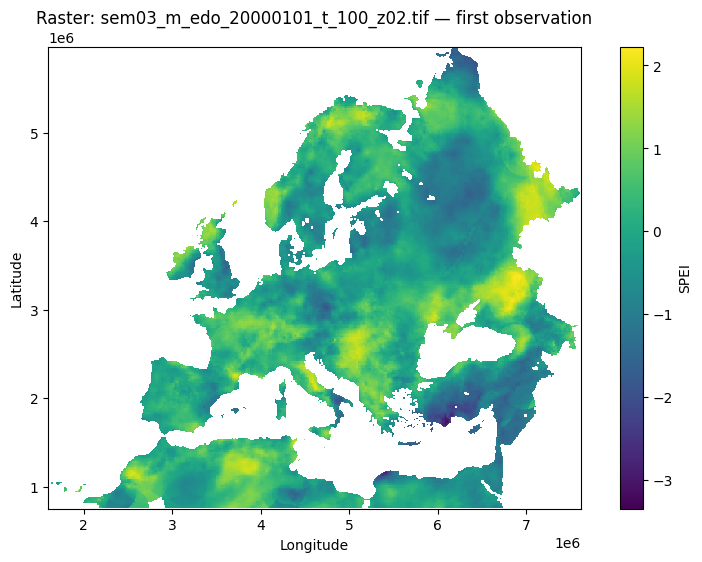

Raster geographic bounds (minx, maxx, miny, maxy): [1600000.0, 7620000.0, 750000.0, 5970000.0]


In [4]:
# --- Pick the first raster observation ---
first_row = df_tiffs.iloc[0]
img = first_row['data']
folder = first_row['folder']
file = first_row['file']
file_path = os.path.join('SPEI_Data', folder, file)

# --- Reopen raster to get transform and CRS ---
with rasterio.open(file_path) as src:
    transform = src.transform
    crs = src.crs
    # Compute geographic bounds
    h, w = src.height, src.width
    minx, miny, maxx, maxy = rasterio.transform.array_bounds(h, w, transform)
    extent = [minx, maxx, miny, maxy]

# --- Mask invalid values ---
masked = np.ma.masked_invalid(img)

# --- Plot raster ---
plt.figure(figsize=(10, 6))
plt.imshow(masked, origin='upper', extent=extent, cmap='viridis')
plt.colorbar(label='SPEI')
plt.title(f"Raster: {file} — first observation")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# --- Print raster extent info ---
print("Raster geographic bounds (minx, maxx, miny, maxy):", extent)


### Plot over Europe

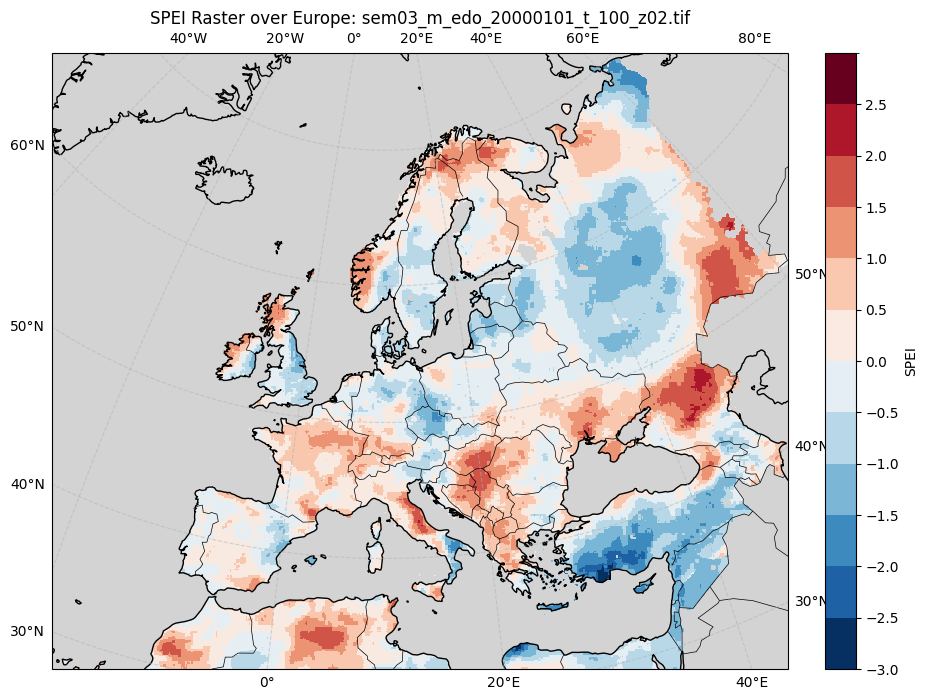

In [5]:
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib import colormaps  # <- new API

# --- Colormap and normalization ---
cmap_name = 'RdBu_r'
cmap = colormaps[cmap_name].copy()   # replace cm.get_cmap()
cmap.set_bad(color='lightgray')      # NaNs appear gray

bounds = np.linspace(-3, 3, 13)
norm = BoundaryNorm(bounds, ncolors=cmap.N)

# Pick a raster file
row = df_tiffs.iloc[0]
file_path = os.path.join('SPEI_Data', row['folder'], row['file'])

# Reopen the tif to get affine transform/crs
with rasterio.open(file_path) as src:
    img = src.read(1)
    transform = src.transform
    crs = src.crs

# Mask invalid values (NaNs)
masked = np.ma.masked_invalid(img)

# Compute raster extent
h, w = img.shape
minx, miny, maxx, maxy = rasterio.transform.array_bounds(h, w, transform)
extent = [minx, maxx, miny, maxy]

# Use raster CRS (EPSG:3035) for correct alignment
img_crs = ccrs.epsg(3035)

# Plot
fig, ax = plt.subplots(figsize=(12,8), subplot_kw={'projection': img_crs})

# Show the raster
im = ax.imshow(masked, origin='upper', extent=extent, transform=img_crs,
               cmap=cmap, norm=norm)

# Optional: zoom to Europe in EPSG:3035 meters
eu_extent_3035 = [1600000, 7600000, 750000, 6000000]  # approximate Europe bounds in EPSG:3035
ax.set_extent(eu_extent_3035, crs=img_crs)

# Map features (Cartopy will reproject them)
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.2)
ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)

# Colorbar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04, ticks=bounds[:-1])
cbar.set_label('SPEI')

ax.set_title(f"SPEI Raster over Europe: {row['file']}")
plt.show()


# Go to Armenia

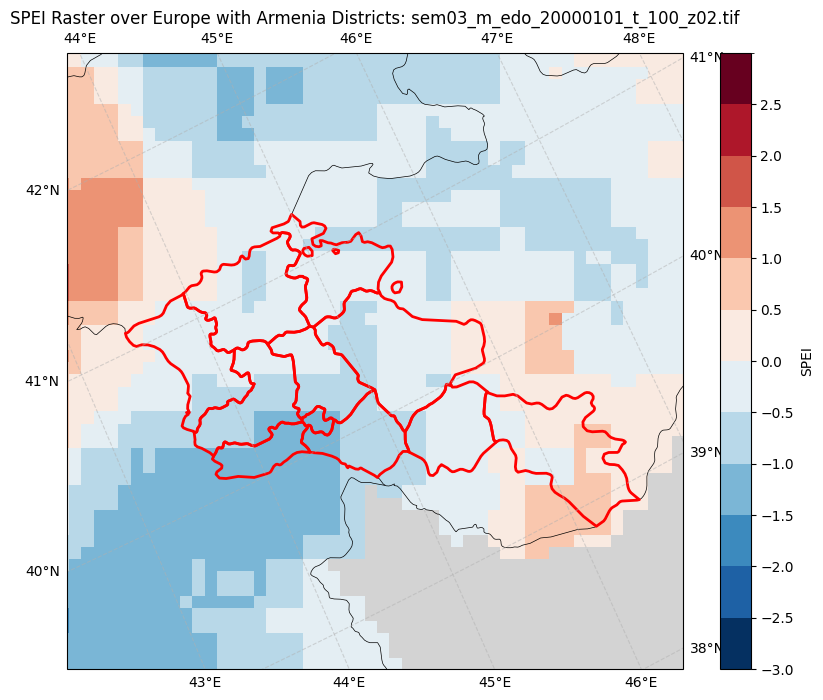

In [6]:
# --- Raster plot setup (Europe view) ---
fig, ax = plt.subplots(figsize=(12,8), subplot_kw={'projection': img_crs})

# Show raster
im = ax.imshow(masked, origin='upper', extent=extent, transform=img_crs,
               cmap=cmap, norm=norm)

# Zoom to Europe
eu_extent_3035 = [7000000, 7400000, 2400000, 2800000]
ax.set_extent(eu_extent_3035, crs=img_crs)

# Map features
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.2)
ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)

# --- Overlay Armenia first-level borders ---
# Ensure districts GeoJSON is in EPSG:3035
districts_fp = 'armenia_shapefile/am.json'
districts = gpd.read_file(districts_fp).to_crs(epsg=3035)

# Add first-level borders
ax.add_geometries(
    districts.geometry,
    crs=img_crs,
    facecolor='none',     # keep transparent fill
    edgecolor='red',      # color of borders
    linewidth=2
)

# Colorbar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04, ticks=bounds[:-1])
cbar.set_label('SPEI')

ax.set_title(f"SPEI Raster over Europe with Armenia Districts: {row['file']}")
plt.show()


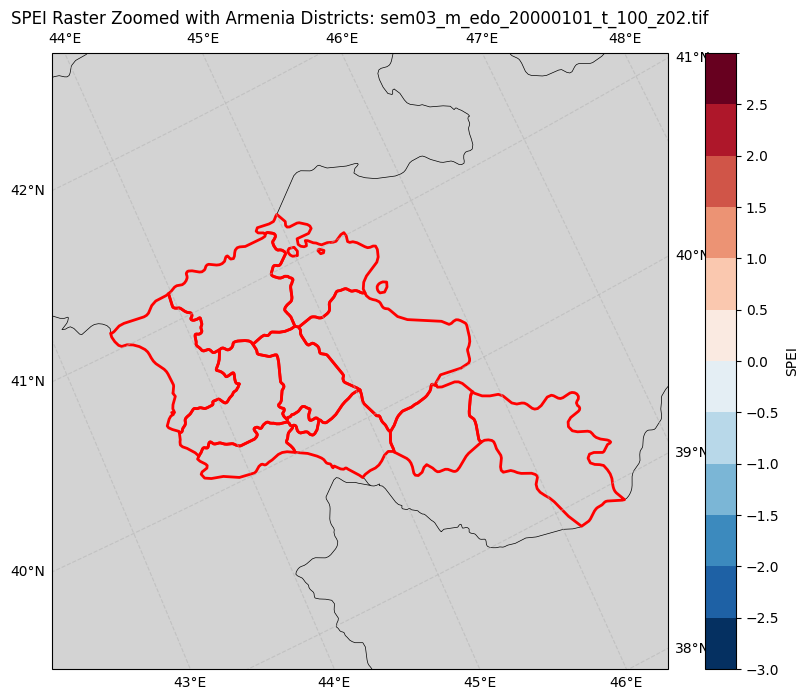

In [7]:
from rasterio.windows import from_bounds

# --- Zoom bounds in EPSG:3035 (your current view) ---
zoom_bounds = [7000000, 7400000, 2400000, 2800000]  # [minx, maxx, miny, maxy]

# --- Intersect with raster bounds to avoid WindowError ---
with rasterio.open(file_path) as src:
    raster_bounds = src.bounds
    minx = max(raster_bounds.left, zoom_bounds[0])
    maxx = min(raster_bounds.right, zoom_bounds[1])
    miny = max(raster_bounds.bottom, zoom_bounds[2])
    maxy = min(raster_bounds.top, zoom_bounds[3])

    window = from_bounds(minx, miny, maxx, maxy, transform=src.transform)
    img_cropped = src.read(1, window=window)
    transform_cropped = src.window_transform(window)

# Mask invalid values
masked_cropped = np.ma.masked_invalid(img_cropped)

# Compute extent for plotting
h, w = img_cropped.shape
extent_cropped = rasterio.transform.array_bounds(h, w, transform_cropped)

# --- Plot cropped raster (fast!) ---
fig, ax = plt.subplots(figsize=(12,8), subplot_kw={'projection': img_crs})

im = ax.imshow(masked_cropped, origin='upper', extent=extent_cropped,
               transform=img_crs, cmap=cmap, norm=norm)

# Keep your preferred zoom and Cartopy features
ax.set_extent(zoom_bounds, crs=img_crs)
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.2)
ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)

# Overlay Armenia first-level borders
districts_fp = 'armenia_shapefile/am.json'
districts = gpd.read_file(districts_fp).to_crs(epsg=3035)

ax.add_geometries(
    districts.geometry,
    crs=img_crs,
    facecolor='none',
    edgecolor='red',
    linewidth=2
)

# Colorbar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04, ticks=bounds[:-1])
cbar.set_label('SPEI')

ax.set_title(f"SPEI Raster Zoomed with Armenia Districts: {row['file']}")
plt.show()


In [8]:
print("Raster extent:", extent_cropped)
print("GeoJSON bounds:", districts.total_bounds)  # minx, miny, maxx, maxy

Raster extent: (7000000.0, 2400000.0, 7400000.0, 2800000.0)
GeoJSON bounds: [7038081.02802978 2492725.83716527 7371829.52801481 2695219.80775859]


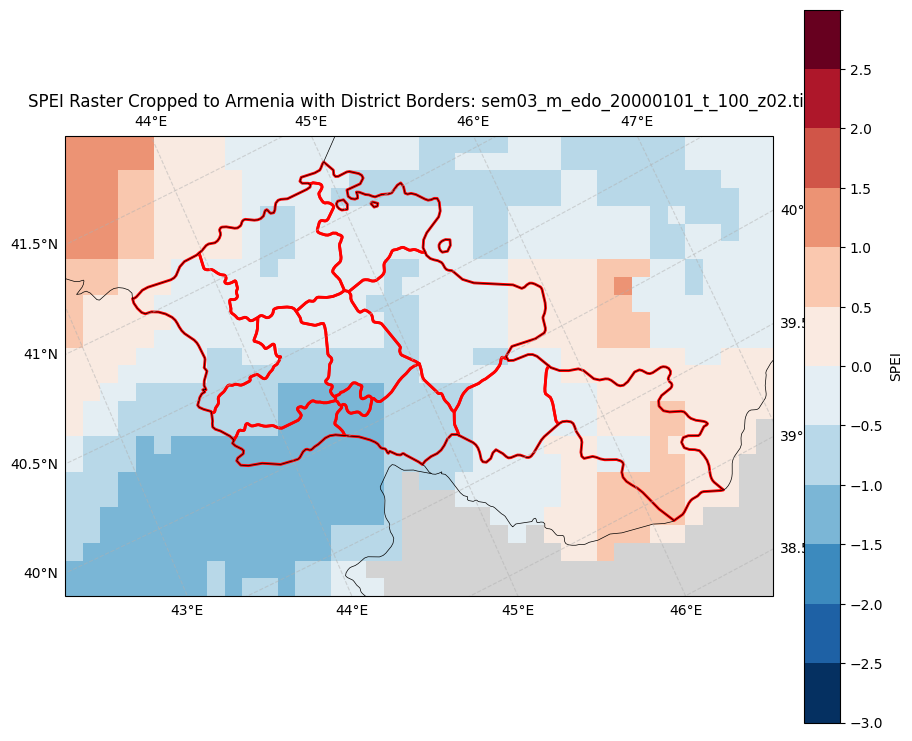

In [9]:
import os
import numpy as np
import rasterio
from rasterio.windows import from_bounds
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib import colormaps
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# --- Colormap setup ---
cmap_name = 'RdBu_r'
cmap = colormaps[cmap_name].copy()
cmap.set_bad(color='lightgray')
bounds = np.linspace(-3, 3, 13)
norm = BoundaryNorm(bounds, ncolors=cmap.N)

# --- Pick the first raster ---
row = df_tiffs.iloc[0]
file_path = os.path.join('SPEI_Data', row['folder'], row['file'])

# --- Armenia bounding box in EPSG:3035 ---
armenia_bounds = [7000000, 7400000, 2450000, 2710000]  # minx, maxx, miny, maxy

# --- Open raster and crop to Armenia ---
with rasterio.open(file_path) as src:
    raster_bounds = src.bounds

    # Intersect with raster bounds
    minx = max(raster_bounds.left, armenia_bounds[0])
    maxx = min(raster_bounds.right, armenia_bounds[1])
    miny = max(raster_bounds.bottom, armenia_bounds[2])
    maxy = min(raster_bounds.top, armenia_bounds[3])

    window = from_bounds(minx, miny, maxx, maxy, transform=src.transform)
    img_cropped = src.read(1, window=window)
    transform_cropped = src.window_transform(window)
    crs = src.crs

# Mask invalid values
masked_cropped = np.ma.masked_invalid(img_cropped)

# Compute correct extent for imshow: [minx, maxx, miny, maxy]
h, w = img_cropped.shape
minx, miny, maxx, maxy = rasterio.transform.array_bounds(h, w, transform_cropped)
extent_cropped = [minx, maxx, miny, maxy]

# --- Load Armenia first-level borders and reproject to raster CRS ---
districts_fp = 'armenia_shapefile/am.json'
districts = gpd.read_file(districts_fp).to_crs(epsg=3035)

# --- Plot ---
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection': ccrs.epsg(3035)})

# Show raster
im = ax.imshow(masked_cropped, origin='upper', extent=extent_cropped,
               transform=ccrs.epsg(3035), cmap=cmap, norm=norm)

# Overlay first-level borders
ax.add_geometries(
    districts.geometry,
    crs=ccrs.epsg(3035),
    facecolor='none',
    edgecolor='red',
    linewidth=2
)

# Optional Cartopy features
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.2)
ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)

# Colorbar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04, ticks=bounds[:-1])
cbar.set_label('SPEI')

ax.set_title(f"SPEI Raster Cropped to Armenia with District Borders: {row['file']}")
plt.show()


# Calculate Distict Averages

In [10]:
from rasterio.features import geometry_mask
import pandas as pd

# Make sure your raster window and transform are set (from the previous cropped plot)
# masked_cropped, transform_cropped

# Store results
district_means = []

for idx, row in districts.iterrows():
    geom = [row['geometry']]  # geometry_mask expects a list of geometries
    
    # Create a mask: True for pixels **outside** the geometry
    mask = geometry_mask(
        geom,
        out_shape=masked_cropped.shape,
        transform=transform_cropped,
        invert=True  # invert=True: True where pixels are inside the polygon
    )
    
    # Extract raster values inside the district
    values = masked_cropped[mask]
    
    # Compute mean (skip NaNs)
    mean_value = np.nan
    if values.size > 0:
        mean_value = values.mean()
    
    district_means.append({
        'district_name': row['name'],  # replace with your district name column
        'mean_spei': mean_value
    })

# Convert to DataFrame
df_districts_spei = pd.DataFrame(district_means)
df_districts_spei


,district_name,mean_spei
0,Tavush,-0.299958
1,Lori,-0.291538
2,Shirak,-0.237458
3,Gegharkunik,-0.284035
4,Vayots Dzor,-0.180073
5,Syunik,0.327941
6,Ararat,-0.808903
7,Aragatsotn,-0.763243
8,Armavir,-1.181219
9,Kotayk,-0.627025


In [11]:
districts.columns


Index(['source', 'id', 'name', 'geometry'], dtype='object')

In [12]:
from rasterio.features import geometry_mask
import pandas as pd
import numpy as np
import os
from tqdm import tqdm  # progress bar

# --- Armenia crop bounds (same as in your plot) ---
armenia_bounds = [7000000, 7400000, 2450000, 2710000]  # minx, maxx, miny, maxy

# Store results
all_districts_stats = []

# Loop over rasters with progress bar
for idx, row_tiff in tqdm(df_tiffs.iterrows(), total=len(df_tiffs), desc="Processing rasters"):
    file_path = os.path.join('SPEI_Data', row_tiff['folder'], row_tiff['file'])
    
    with rasterio.open(file_path) as src:
        # Crop raster to Armenia bounds for speed
        raster_bounds = src.bounds

        minx = max(raster_bounds.left, armenia_bounds[0])
        maxx = min(raster_bounds.right, armenia_bounds[1])
        miny = max(raster_bounds.bottom, armenia_bounds[2])
        maxy = min(raster_bounds.top, armenia_bounds[3])

        window = from_bounds(minx, miny, maxx, maxy, transform=src.transform)
        img_cropped = src.read(1, window=window)
        transform_cropped = src.window_transform(window)
    
    masked = np.ma.masked_invalid(img_cropped)
    
    # Loop over districts
    for idx_d, row_d in districts.iterrows():
        geom = [row_d['geometry']]

        mask = geometry_mask(
            geom,
            out_shape=masked.shape,
            transform=transform_cropped,
            invert=True
        )
        
        values = masked[mask]
        mean_value = np.nan
        if values.size > 0:
            mean_value = values.mean()
        
        all_districts_stats.append({
            'file': row_tiff['file'],
            'district_name': row_d['name'],
            'mean_spei': mean_value
        })

# Convert to DataFrame
df_all_districts_spei = pd.DataFrame(all_districts_stats)
df_all_districts_spei.head()


Processing rasters: 100%|██████████| 929/929 [00:47<00:00, 19.36it/s]


,file,district_name,mean_spei
0,sem03_m_edo_20000101_t_100_z02.tif,Tavush,-0.299958
1,sem03_m_edo_20000101_t_100_z02.tif,Lori,-0.291538
2,sem03_m_edo_20000101_t_100_z02.tif,Shirak,-0.237458
3,sem03_m_edo_20000101_t_100_z02.tif,Gegharkunik,-0.284035
4,sem03_m_edo_20000101_t_100_z02.tif,Vayots Dzor,-0.180073


In [13]:
# --- Extract date from filename afterward ---
df_all_districts_spei['date'] = pd.to_datetime(
    df_all_districts_spei['file'].str.split('_').str[3],
    format='%Y%m%d'
)

df_all_districts_spei.head()


,file,district_name,mean_spei,date
0,sem03_m_edo_20000101_t_100_z02.tif,Tavush,-0.299958,2000-01-01
1,sem03_m_edo_20000101_t_100_z02.tif,Lori,-0.291538,2000-01-01
2,sem03_m_edo_20000101_t_100_z02.tif,Shirak,-0.237458,2000-01-01
3,sem03_m_edo_20000101_t_100_z02.tif,Gegharkunik,-0.284035,2000-01-01
4,sem03_m_edo_20000101_t_100_z02.tif,Vayots Dzor,-0.180073,2000-01-01


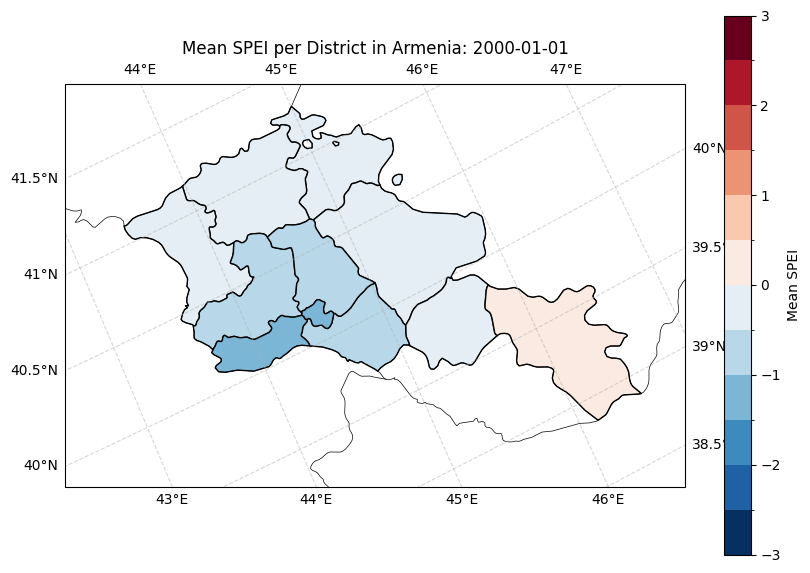

In [14]:
from matplotlib.colors import BoundaryNorm
from matplotlib import colormaps

# --- Colormap setup (fixed) ---
cmap_name = 'RdBu_r'
cmap = colormaps[cmap_name].copy()
cmap.set_bad(color='lightgray')
bounds = np.linspace(-3, 3, 13)  # same as raster
norm = BoundaryNorm(bounds, ncolors=cmap.N)

# --- Pick a date to visualize ---
date_to_plot = pd.Timestamp('2000-01-01')
df_plot = df_all_districts_spei[df_all_districts_spei['date'] == date_to_plot]

# Merge district GeoJSON with mean SPEI values
districts_plot = districts.merge(df_plot, left_on='name', right_on='district_name')

# --- Plot ---
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection': ccrs.epsg(3035)})

# Plot SPEI values per district with fixed color scale
districts_plot.plot(
    column='mean_spei',
    ax=ax,
    cmap=cmap,
    norm=norm,
    edgecolor='black',
    linewidth=1,
    legend=True,
    legend_kwds={'label': "Mean SPEI", 'shrink': 0.7},
    transform=ccrs.epsg(3035)
)

# Optional Cartopy features
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)

# Set plot extent to Armenia bounds
ax.set_extent([armenia_bounds[0], armenia_bounds[1], armenia_bounds[2], armenia_bounds[3]],
              crs=ccrs.epsg(3035))

ax.set_title(f"Mean SPEI per District in Armenia: {date_to_plot.date()}")
plt.show()


In [15]:
# from tqdm import tqdm
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
# from matplotlib.colors import BoundaryNorm
# from matplotlib import colormaps
# import geopandas as gpd
# from matplotlib.animation import PillowWriter, FuncAnimation

# # --- Colormap setup ---
# cmap_name = 'RdBu_r'
# cmap = colormaps[cmap_name].copy()
# cmap.set_bad(color='lightgray')
# bounds = np.linspace(-3, 3, 13)
# norm = BoundaryNorm(bounds, ncolors=cmap.N)

# # --- Select every 12th date ---
# dates = sorted(df_all_districts_spei['date'].unique())[::12]

# # --- Plot setup ---
# fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection': ccrs.epsg(3035)})

# # Add colorbar once
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
# cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04, ticks=bounds[:-1])
# cbar.set_label('Mean SPEI')

# # --- Optional: overlay Armenia borders ---
# districts_plot = districts.copy()  # just geometry
# districts_plot = districts_plot.to_crs(epsg=3035)

# # --- Loop manually to create frames and track progress ---
# frames = []
# for frame_date in tqdm(dates, desc="Creating animation frames"):
#     ax.clear()
    
#     # Cartopy features
#     ax.coastlines(resolution='50m')
#     ax.add_feature(cfeature.BORDERS, linewidth=0.5)
#     ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
#     ax.set_extent([armenia_bounds[0], armenia_bounds[1], armenia_bounds[2], armenia_bounds[3]],
#                   crs=ccrs.epsg(3035))
    
#     # Merge SPEI values for the current date
#     df_plot = df_all_districts_spei[df_all_districts_spei['date'] == frame_date]
#     districts_current = districts_plot.merge(df_plot, left_on='name', right_on='district_name')
    
#     # Plot choropleth
#     districts_current.plot(
#         column='mean_spei',
#         ax=ax,
#         cmap=cmap,
#         norm=norm,
#         edgecolor='red',   # red borders
#         linewidth=2,
#         transform=ccrs.epsg(3035)
#     )
    
#     ax.set_title(f"Mean SPEI per District in Armenia: {frame_date.date()}")
    
#     # Capture current frame as an image for GIF
#     fig.canvas.draw()
#     image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
#     image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
#     frames.append(image)

# plt.close(fig)

# # --- Save as GIF ---
# import imageio
# imageio.mimsave("armenia_spei_animation.gif", frames, fps=2)


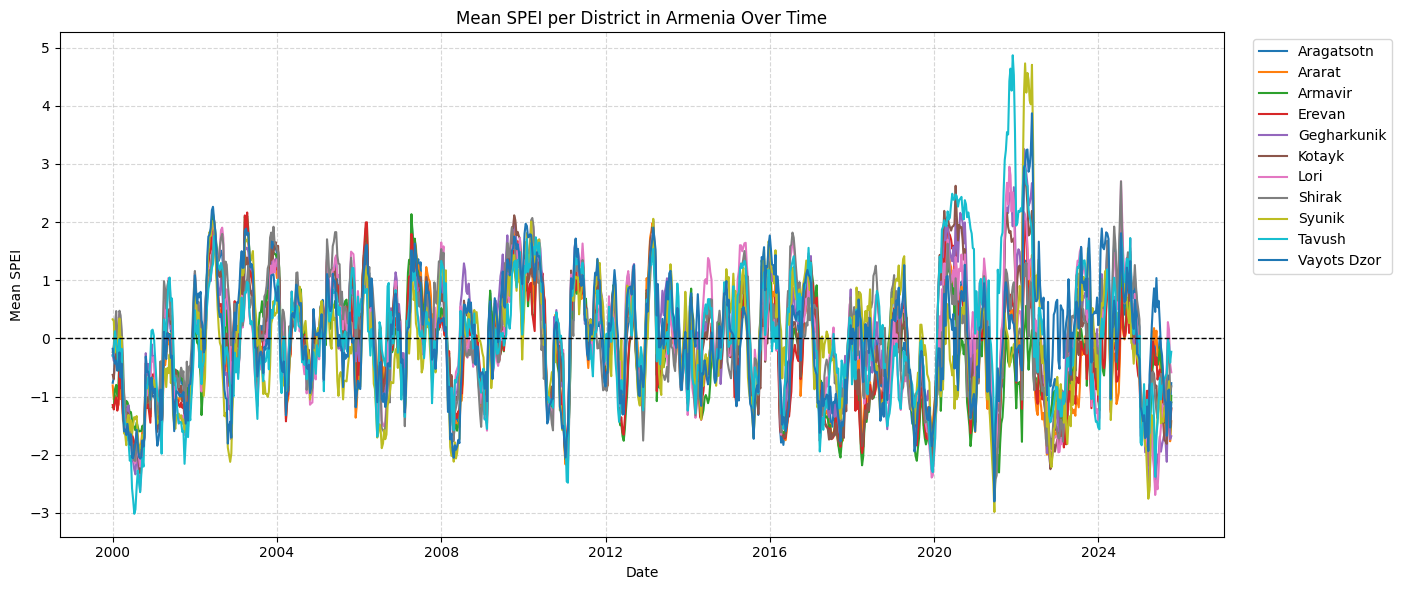

In [16]:
import matplotlib.pyplot as plt

# --- Pivot data for easier plotting ---
df_ts = df_all_districts_spei.pivot(index='date', columns='district_name', values='mean_spei')

# --- Plot ---
plt.figure(figsize=(14,6))

for district in df_ts.columns:
    plt.plot(df_ts.index, df_ts[district], label=district)

plt.axhline(0, color='black', linestyle='--', linewidth=1)  # zero reference
plt.title("Mean SPEI per District in Armenia Over Time")
plt.xlabel("Date")
plt.ylabel("Mean SPEI")
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


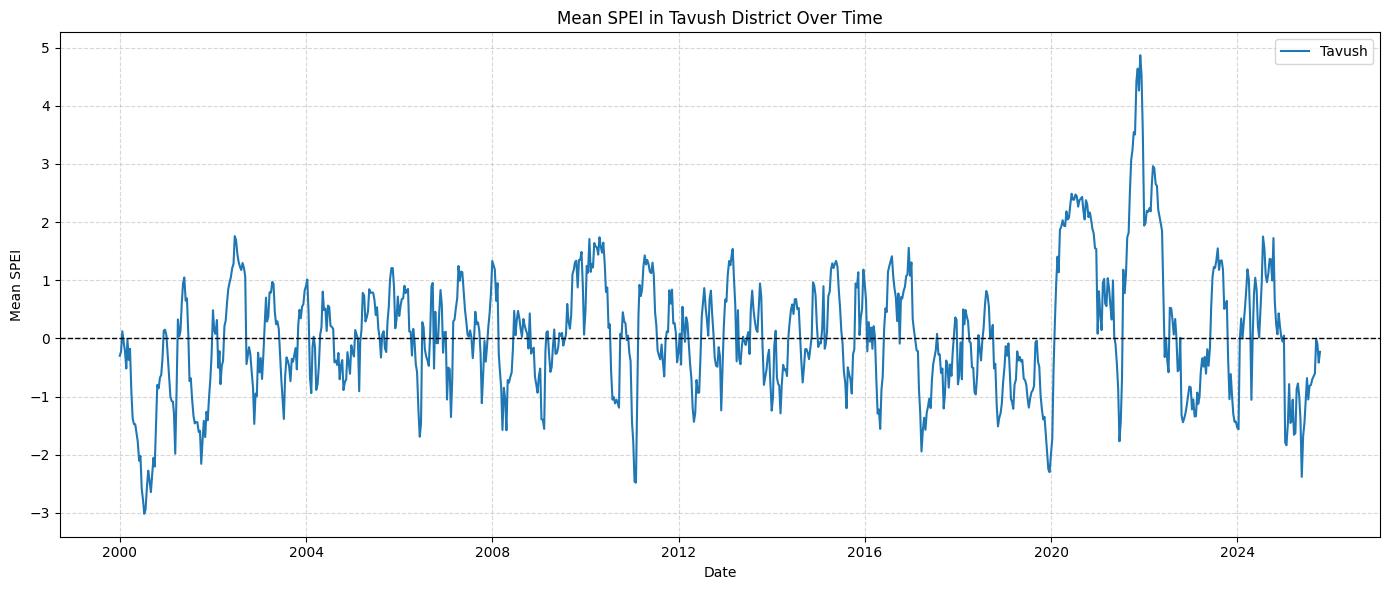

In [17]:
import matplotlib.pyplot as plt

# --- Pivot data for easier plotting ---
df_ts = df_all_districts_spei.pivot(index='date', columns='district_name', values='mean_spei')

# --- Plot only Tavush ---
plt.figure(figsize=(14,6))
plt.plot(df_ts.index, df_ts['Tavush'], label='Tavush', color='tab:blue')

# Zero reference line
plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.title("Mean SPEI in Tavush District Over Time")
plt.xlabel("Date")
plt.ylabel("Mean SPEI")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


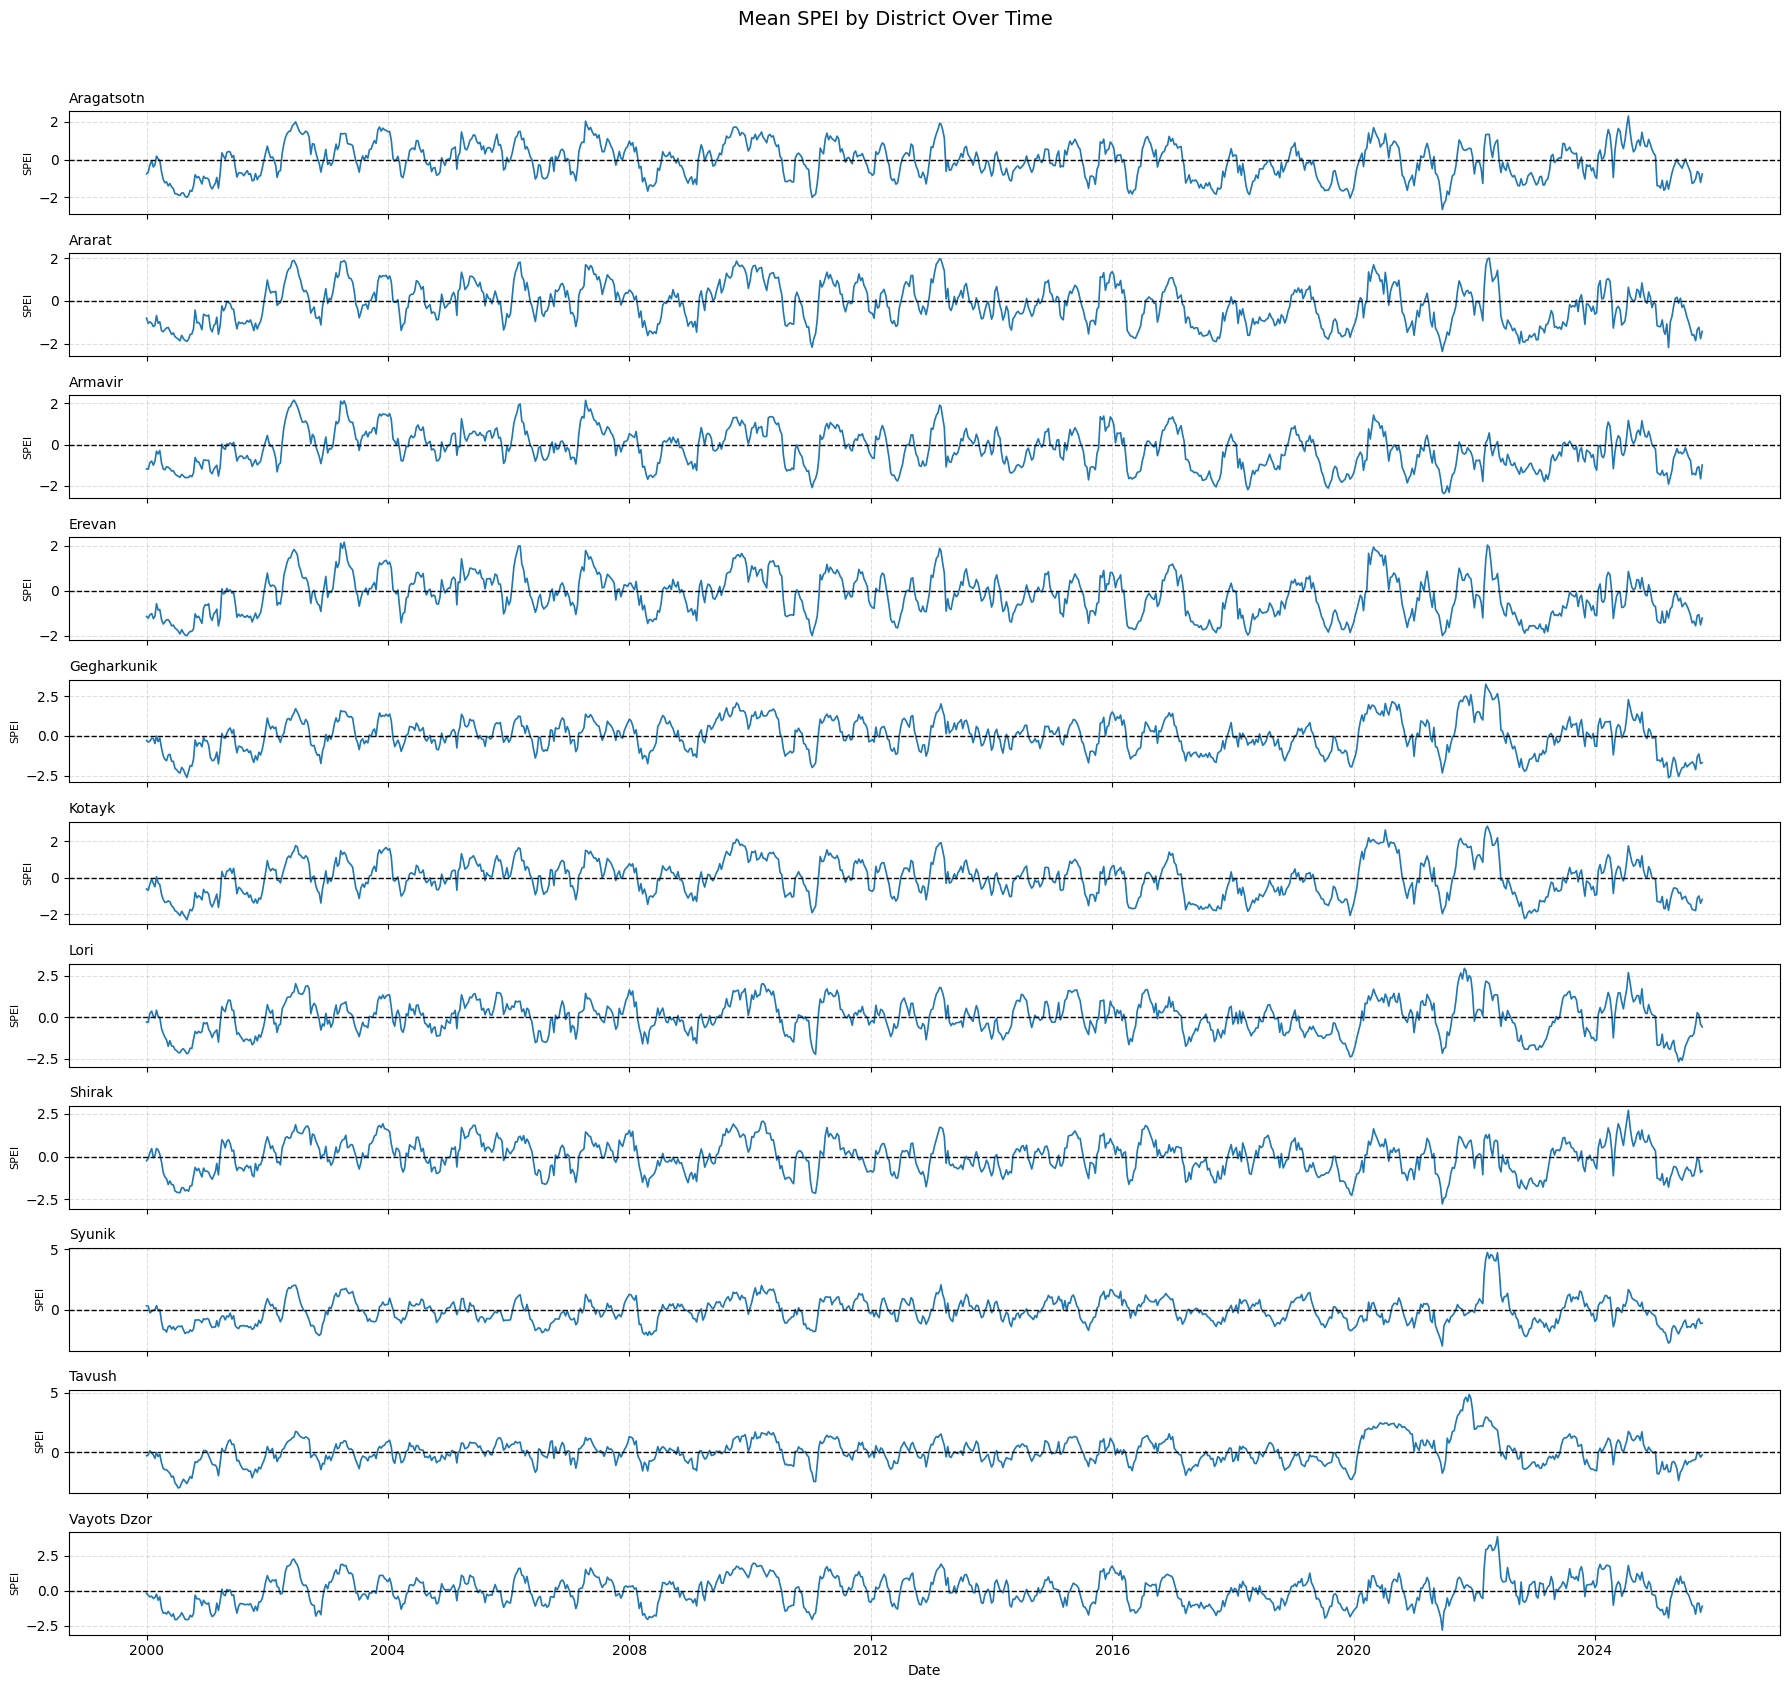

In [37]:
import matplotlib.pyplot as plt

# --- Pivot data for easier plotting ---
df_ts = df_all_districts_spei.pivot(index='date', columns='district_name', values='mean_spei')

# --- Create subplots ---
n_districts = len(df_ts.columns)
fig, axes = plt.subplots(n_districts, 1, figsize=(18, n_districts * 1.5), sharex=True)

# --- Plot each district ---
for ax, district in zip(axes, df_ts.columns):
    ax.plot(df_ts.index, df_ts[district], color='tab:blue', linewidth=1.2)
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.set_title(district, fontsize=10, loc='left')
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.set_ylabel("SPEI", fontsize=8)

# --- Shared X-axis and final formatting ---
plt.xlabel("Date")
plt.suptitle("Mean SPEI by District Over Time", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


In [18]:
# --- Ensure 'date' is a datetime ---
df_all_districts_spei['date'] = pd.to_datetime(df_all_districts_spei['date'])

# --- Extract year ---
df_all_districts_spei['year'] = df_all_districts_spei['date'].dt.year

# --- Aggregate per year and district ---
df_annual_spei = (
    df_all_districts_spei
    .groupby(['district_name', 'year'], as_index=False)
    .agg(mean_spei_year=('mean_spei', 'mean'))
)

# --- Inspect ---
print(df_annual_spei.head())


  district_name  year  mean_spei_year
0    Aragatsotn  2000       -1.129461
1    Aragatsotn  2001       -0.612033
2    Aragatsotn  2002        0.683806
3    Aragatsotn  2003        0.644137
4    Aragatsotn  2004        0.062048


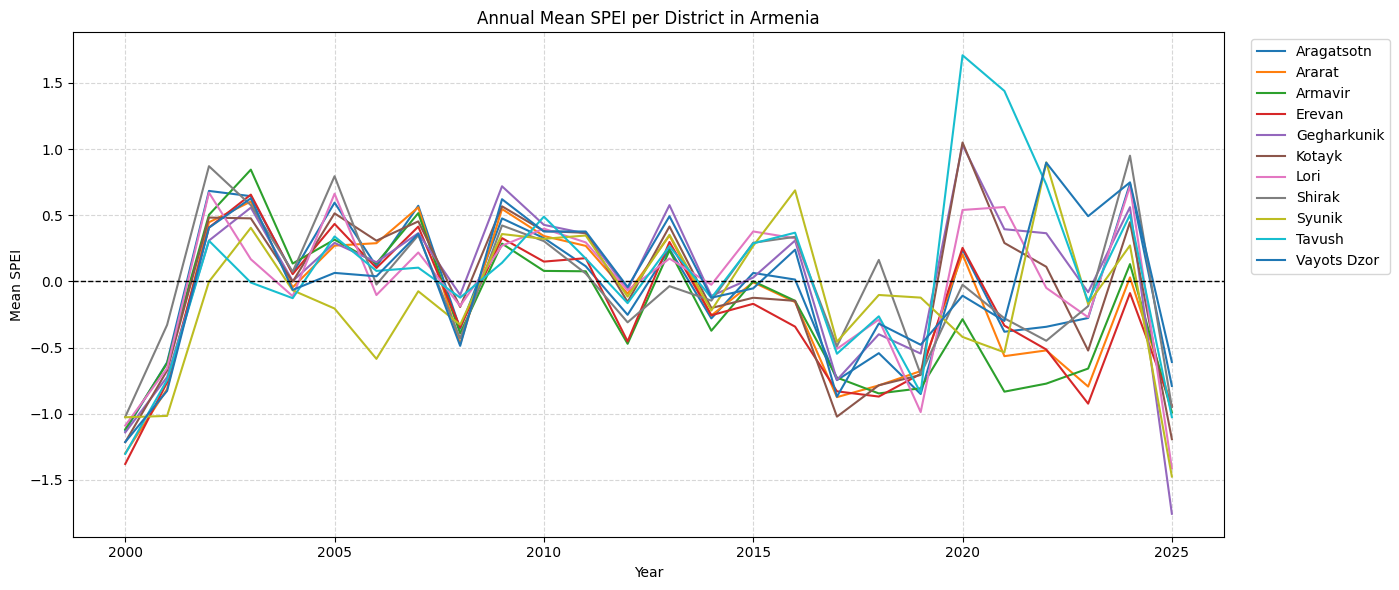

In [19]:
import matplotlib.pyplot as plt

# Pivot data for easier plotting: rows = year, columns = district, values = mean SPEI
df_ts = df_annual_spei.pivot(index='year', columns='district_name', values='mean_spei_year')

# Plot
plt.figure(figsize=(14,6))

for district in df_ts.columns:
    plt.plot(df_ts.index, df_ts[district], label=district)

# Reference line at SPEI = 0
plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.title("Annual Mean SPEI per District in Armenia")
plt.xlabel("Year")
plt.ylabel("Mean SPEI")
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [20]:
def max_consecutive_below(series, threshold=-2):
    """
    Returns the maximum number of consecutive months where the series <= threshold.
    """
    max_count = 0
    count = 0
    for val in series:
        if val <= threshold:
            count += 1
            if count > max_count:
                max_count = count
        else:
            count = 0
    return max_count


In [21]:
import pandas as pd
import numpy as np

# Assume df_all_districts_spei has columns: 'date', 'district_name', 'mean_spei'
df = df_all_districts_spei.copy()
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

# --- Function to check 3 consecutive observations <= -2 ---
def check_consecutive_drought(series, threshold=-2, n_consecutive=3):
    condition_met = series <= threshold
    count = 0
    for val in condition_met:
        if val:
            count += 1
            if count >= n_consecutive:
                return 1
        else:
            count = 0
    return 0

# --- Function to check at least 3 drought months (not necessarily consecutive) ---
def check_total_droughts(series, threshold=-1.5, n_required=4):
    return int((series <= threshold).sum() >= n_required)

# --- Group by year and district ---
records = []
for (district, year), group in df.groupby(['district_name', 'year']):
    drought_consecutive = check_consecutive_drought(group['mean_spei'].values, threshold=-1.8, n_consecutive=3)
    drought_total = check_total_droughts(group['mean_spei'].values, threshold=-1.8, n_required=5)
    records.append({
        'district_name': district,
        'year': year,
        'dummy_drought_consecutive': drought_consecutive,
        'dummy_drought_total': drought_total
    })

df_yearly_drought = pd.DataFrame(records)

# --- Inspect ---
print(df_yearly_drought.head())


  district_name  year  dummy_drought_consecutive  dummy_drought_total
0    Aragatsotn  2000                          1                    1
1    Aragatsotn  2001                          0                    0
2    Aragatsotn  2002                          0                    0
3    Aragatsotn  2003                          0                    0
4    Aragatsotn  2004                          0                    0


In [22]:
df_yearly_drought.head()


,district_name,year,dummy_drought_consecutive,dummy_drought_total
0,Aragatsotn,2000,1,1
1,Aragatsotn,2001,0,0
2,Aragatsotn,2002,0,0
3,Aragatsotn,2003,0,0
4,Aragatsotn,2004,0,0


In [23]:
df_all_districts_spei.head()

,file,district_name,mean_spei,date,year
0,sem03_m_edo_20000101_t_100_z02.tif,Tavush,-0.299958,2000-01-01,2000
1,sem03_m_edo_20000101_t_100_z02.tif,Lori,-0.291538,2000-01-01,2000
2,sem03_m_edo_20000101_t_100_z02.tif,Shirak,-0.237458,2000-01-01,2000
3,sem03_m_edo_20000101_t_100_z02.tif,Gegharkunik,-0.284035,2000-01-01,2000
4,sem03_m_edo_20000101_t_100_z02.tif,Vayots Dzor,-0.180073,2000-01-01,2000


In [24]:
import pandas as pd
import numpy as np

# --- Copy and prepare data ---
df = df_all_districts_spei.copy()
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

# --- Functions ---
def check_consecutive_drought(series, threshold=-2, n_consecutive=3):
    condition_met = series <= threshold
    count = 0
    for val in condition_met:
        if val:
            count += 1
            if count >= n_consecutive:
                return 1
        else:
            count = 0
    return 0

def check_total_droughts(series, threshold=-2, n_required=3):
    return int((series <= threshold).sum() >= n_required)

# --- Group by district and year ---
records = []
for (district, year), group in df.groupby(['district_name', 'year']):
    mean_spei = group['mean_spei'].mean()
    sum_spei = group['mean_spei'].sum()
    drought_consecutive = check_consecutive_drought(group['mean_spei'].values, threshold=-1, n_consecutive=10)
    drought_total = check_total_droughts(group['mean_spei'].values, threshold=-2, n_required=3)
    max_consec = max_consecutive_below(group['mean_spei'].values, threshold=0)  # NEW
    records.append({
        'district_name': district,
        'year': year,
        'mean_spei_year': mean_spei,
        'sum_spei_year': sum_spei,
        'dummy_drought_consecutive': drought_consecutive,
        'dummy_drought_total': drought_total,
        'max_consecutive_below_minus2': max_consec  # NEW
    })

df_yearly_spei = pd.DataFrame(records)

# --- Inspect ---
print(df_yearly_spei.head())


  district_name  year  mean_spei_year  sum_spei_year  \
0    Aragatsotn  2000       -1.129461     -40.660580   
1    Aragatsotn  2001       -0.612033     -22.033186   
2    Aragatsotn  2002        0.683806      24.617024   
3    Aragatsotn  2003        0.644137      23.188917   
4    Aragatsotn  2004        0.062048       2.233721   

   dummy_drought_consecutive  dummy_drought_total  \
0                          1                    0   
1                          0                    0   
2                          0                    0   
3                          0                    0   
4                          0                    0   

   max_consecutive_below_minus2  
0                            28  
1                            18  
2                             5  
3                             4  
4                            10  


In [25]:
df_yearly_spei

,district_name,year,mean_spei_year,sum_spei_year,dummy_drought_consecutive,dummy_drought_total,max_consecutive_below_minus2
0,Aragatsotn,2000,-1.129461,-40.660580,1,0,28
1,Aragatsotn,2001,-0.612033,-22.033186,0,0,18
2,Aragatsotn,2002,0.683806,24.617024,0,0,5
3,Aragatsotn,2003,0.644137,23.188917,0,0,4
4,Aragatsotn,2004,0.062048,2.233721,0,0,10
...,...,...,...,...,...,...,...
281,Vayots Dzor,2021,-0.299159,-10.769739,0,0,12
282,Vayots Dzor,2022,0.897601,32.313640,0,0,6
283,Vayots Dzor,2023,0.492686,17.736706,0,0,2
284,Vayots Dzor,2024,0.748587,26.949140,0,0,2


    year  total_consecutive  total_total  pct_consecutive  pct_total
0   2000                 11            6       100.000000  54.545455
1   2001                  4            0        36.363636   0.000000
2   2002                  0            0         0.000000   0.000000
3   2003                  0            0         0.000000   0.000000
4   2004                  0            0         0.000000   0.000000
5   2005                  0            0         0.000000   0.000000
6   2006                  1            0         9.090909   0.000000
7   2007                  0            0         0.000000   0.000000
8   2008                  1            1         9.090909   9.090909
9   2009                  0            0         0.000000   0.000000
10  2010                  0            0         0.000000   0.000000
11  2011                  0            1         0.000000   9.090909
12  2012                  0            0         0.000000   0.000000
13  2013                  0       

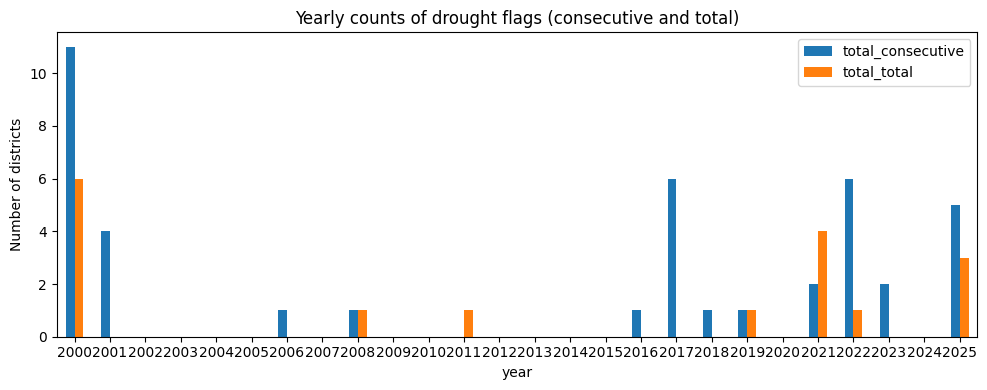

In [26]:
# --- Sum drought dummies by year (counts and percentages) ---
n_districts = df_yearly_spei['district_name'].nunique()

df_drought_summary_by_year = (
    df_yearly_spei
    .groupby('year', as_index=False)
    .agg(
        total_consecutive=('dummy_drought_consecutive', 'sum'),
        total_total=('dummy_drought_total', 'sum')
    )
)

# add percent of districts affected
df_drought_summary_by_year['pct_consecutive'] = (df_drought_summary_by_year['total_consecutive'] / n_districts) * 100
df_drought_summary_by_year['pct_total'] = (df_drought_summary_by_year['total_total'] / n_districts) * 100

# display summary
print(df_drought_summary_by_year)

# optional quick plot
ax = df_drought_summary_by_year.set_index('year')[['total_consecutive', 'total_total']].plot(
    kind='bar', figsize=(10,4), rot=0
)
ax.set_ylabel('Number of districts')
ax.set_title('Yearly counts of drought flags (consecutive and total)')
plt.tight_layout()

In [27]:
df_drought_summary_by_year

,year,total_consecutive,total_total,pct_consecutive,pct_total
0,2000,11,6,100.000000,54.545455
1,2001,4,0,36.363636,0.000000
2,2002,0,0,0.000000,0.000000
3,2003,0,0,0.000000,0.000000
4,2004,0,0,0.000000,0.000000
5,2005,0,0,0.000000,0.000000
6,2006,1,0,9.090909,0.000000
7,2007,0,0,0.000000,0.000000
8,2008,1,1,9.090909,9.090909
9,2009,0,0,0.000000,0.000000


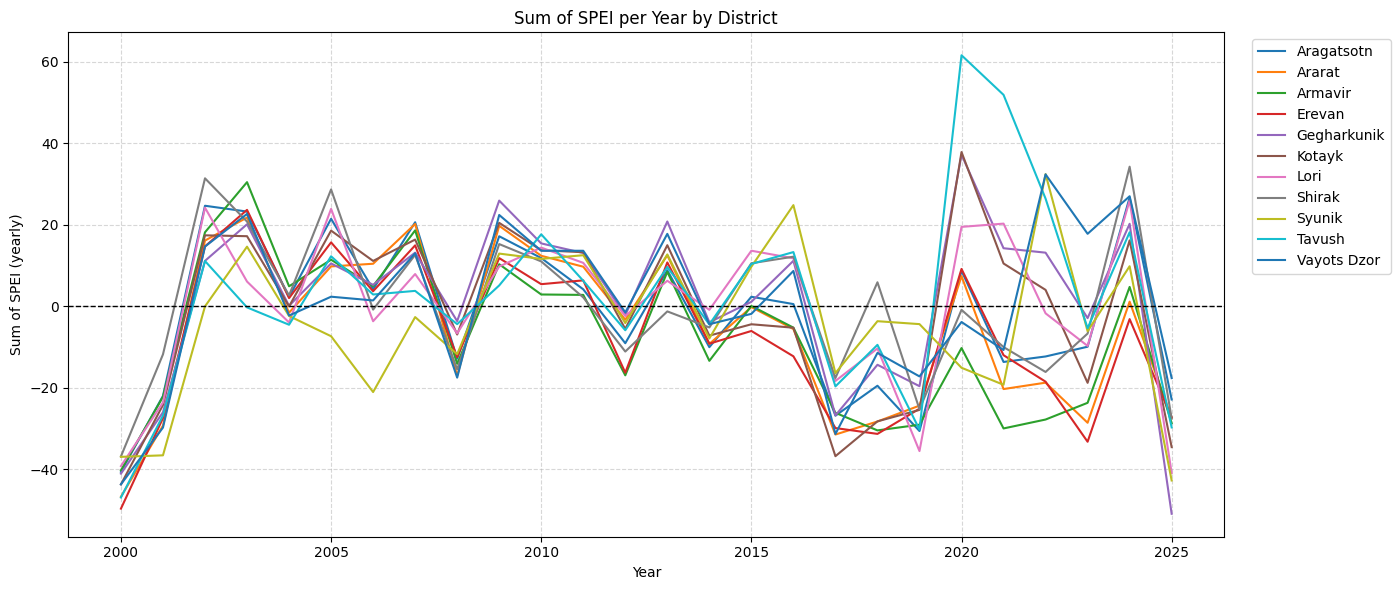

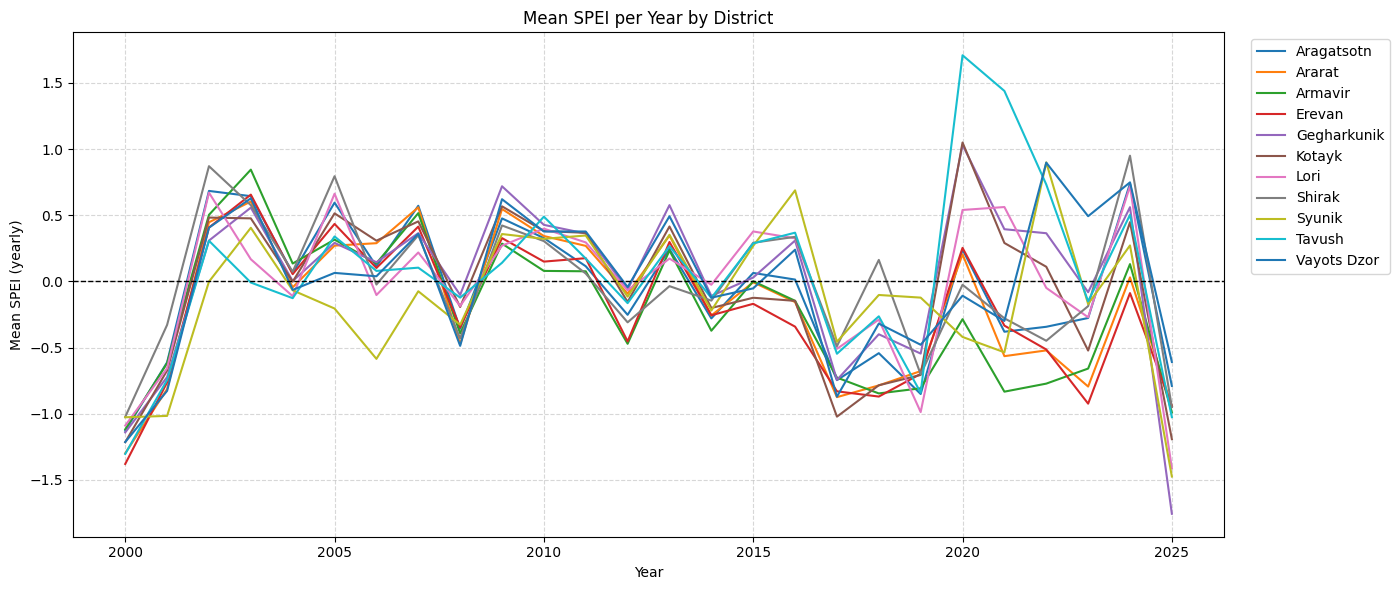

In [28]:
import matplotlib.pyplot as plt

# --- Time series of yearly SPEI sum ---
plt.figure(figsize=(14,6))
for district in df_yearly_spei['district_name'].unique():
    subset = df_yearly_spei[df_yearly_spei['district_name'] == district]
    plt.plot(subset['year'], subset['sum_spei_year'], label=district)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("Sum of SPEI per Year by District")
plt.xlabel("Year")
plt.ylabel("Sum of SPEI (yearly)")
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --- Time series of yearly SPEI mean ---
plt.figure(figsize=(14,6))
for district in df_yearly_spei['district_name'].unique():
    subset = df_yearly_spei[df_yearly_spei['district_name'] == district]
    plt.plot(subset['year'], subset['mean_spei_year'], label=district)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("Mean SPEI per Year by District")
plt.xlabel("Year")
plt.ylabel("Mean SPEI (yearly)")
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


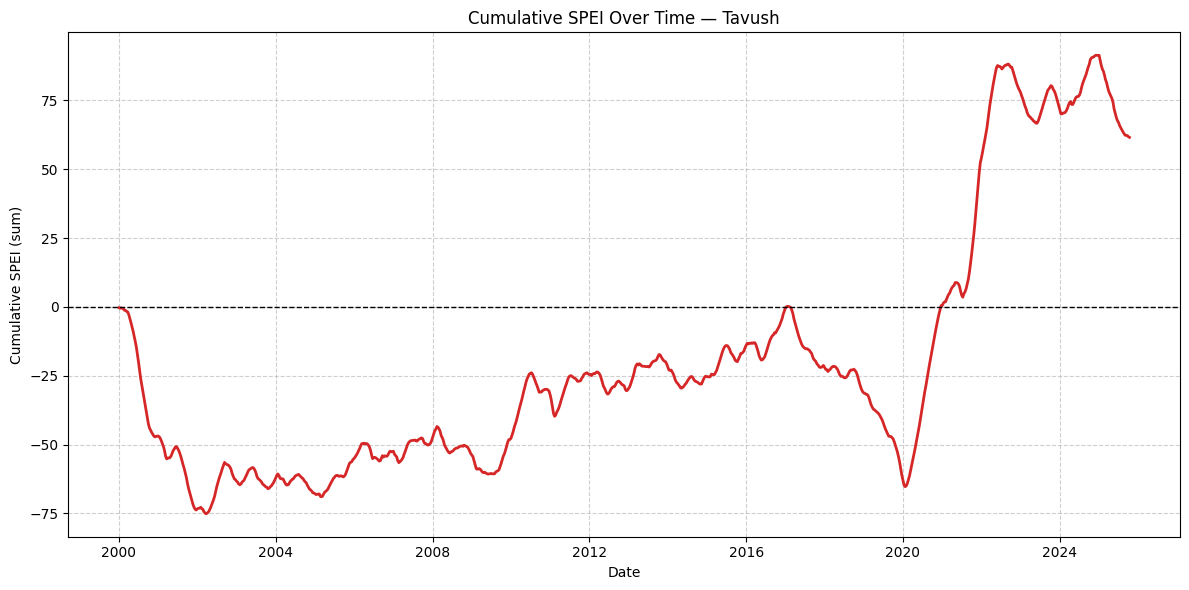

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Copy and sort data ---
df = df_all_districts_spei.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['district_name', 'date'])

# --- Continuous cumulative SPEI sum per district ---
df['spei_cumsum'] = df.groupby('district_name')['mean_spei'].cumsum()

# --- Plot for one district (e.g., Tavush) ---
district_to_plot = "Tavush"

df_tavush = df[df['district_name'] == district_to_plot]

plt.figure(figsize=(12, 6))
plt.plot(df_tavush['date'], df_tavush['spei_cumsum'], color='tab:red', linewidth=2)
plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.title(f"Cumulative SPEI Over Time — {district_to_plot}")
plt.xlabel("Date")
plt.ylabel("Cumulative SPEI (sum)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [30]:
# sort first by year, then by district name
df_yearly_spei_2 = df_yearly_spei.copy()
df_yearly_spei_2 = df_yearly_spei_2.sort_values(['year', 'district_name']).reset_index(drop=True)
df_yearly_spei_2.drop(columns=['mean_spei_year', 'sum_spei_year', 'dummy_drought_total'], inplace=True)
df_yearly_spei_2.head()

,district_name,year,dummy_drought_consecutive,max_consecutive_below_minus2
0,Aragatsotn,2000,1,28
1,Ararat,2000,1,36
2,Armavir,2000,1,36
3,Erevan,2000,1,36
4,Gegharkunik,2000,1,36


In [31]:
# keep only years >= 2011

# quick check
print(df_yearly_spei_2['year'].min(), "to", df_yearly_spei_2['year'].max())

# once a district-year has dummy==1, keep it 1 for all subsequent years for that district
#df_yearly_spei_2 = df_yearly_spei_2.sort_values(['district_name', 'year']).reset_index(drop=True)
#df_yearly_spei_2['dummy_drought_consecutive'] = df_yearly_spei_2.groupby('district_name')['dummy_drought_consecutive'].cummax()

# quick check
print(df_yearly_spei_2.groupby('district_name')['dummy_drought_consecutive'].unique().head())

2000 to 2025
district_name
Aragatsotn     [1, 0]
Ararat         [1, 0]
Armavir        [1, 0]
Erevan         [1, 0]
Gegharkunik    [1, 0]
Name: dummy_drought_consecutive, dtype: object


In [32]:
df_yearly_spei_2

,district_name,year,dummy_drought_consecutive,max_consecutive_below_minus2
0,Aragatsotn,2000,1,28
1,Ararat,2000,1,36
2,Armavir,2000,1,36
3,Erevan,2000,1,36
4,Gegharkunik,2000,1,36
...,...,...,...,...
281,Lori,2025,1,24
282,Shirak,2025,0,28
283,Syunik,2025,1,29
284,Tavush,2025,0,28


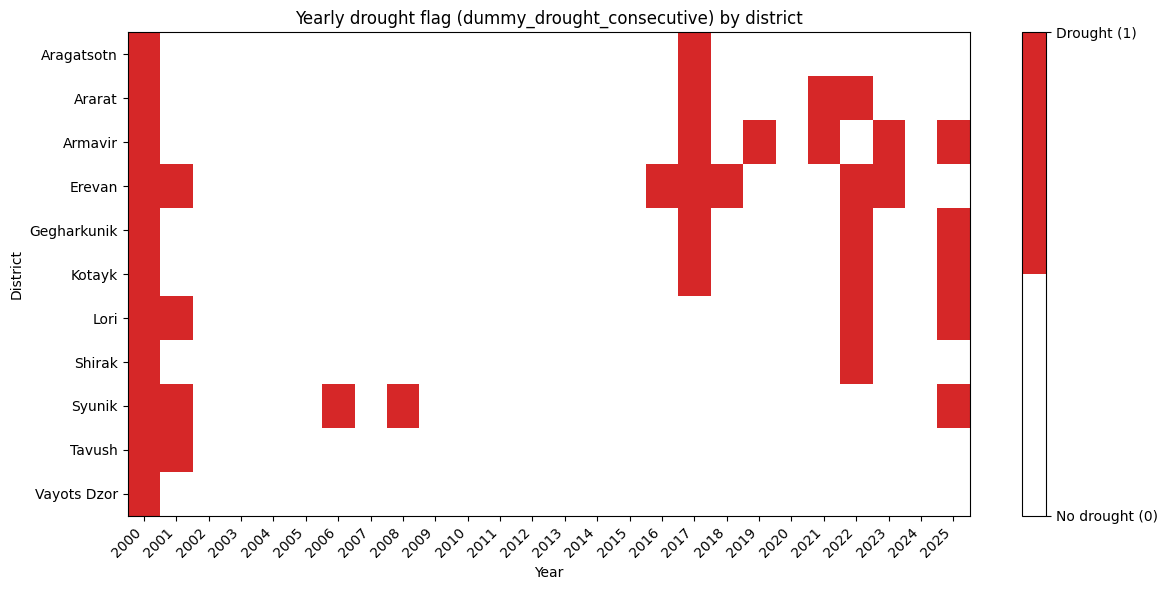

In [33]:
# Heatmap: yearly dummy_drought_consecutive for each district
# uses existing df_yearly_spei_2

# pivot to matrix (rows = district, cols = year)
pivot = df_yearly_spei_2.pivot(index='district_name', columns='year', values='dummy_drought_consecutive')

# fill missing with 0 (no flag) and ensure integer type
pivot = pivot.fillna(0).astype(int)

years = pivot.columns.tolist()
districts = pivot.index.tolist()
data = pivot.values

fig, ax = plt.subplots(figsize=(12, 6))

# discrete colormap: 0 -> white (no drought), 1 -> red (drought)
cmap_flag = ListedColormap(['white', 'tab:red'])
im = ax.imshow(data, aspect='auto', cmap=cmap_flag, vmin=0, vmax=1)

# ticks and labels
ax.set_xticks(range(len(years)))
ax.set_xticklabels(years, rotation=45, ha='right')
ax.set_yticks(range(len(districts)))
ax.set_yticklabels(districts)

ax.set_xlabel('Year')
ax.set_ylabel('District')
ax.set_title('Yearly drought flag (dummy_drought_consecutive) by district')

# colorbar with meaningful labels
cbar = fig.colorbar(im, ax=ax, ticks=[0, 1])
cbar.ax.set_yticklabels(['No drought (0)', 'Drought (1)'])

plt.tight_layout()
plt.show()

In [34]:
pivot.to_csv('district_yearly_drought_treatment.csv')

In [35]:
# Convert the pivot table (wide) to long (tidy) format
df_long = pivot.reset_index().melt(
    id_vars='district_name',
    var_name='year',
    value_name='dummy_drought_consecutive'
)

# Ensure correct dtypes and ordering
df_long['year'] = df_long['year'].astype(int)
df_long = df_long.sort_values(['district_name', 'year']).reset_index(drop=True)

# Quick check
df_long.head()
df_long.to_csv('district_yearly_drought_treatment_long.csv', index=False)

In [36]:
df_long

,district_name,year,dummy_drought_consecutive
0,Aragatsotn,2000,1
1,Aragatsotn,2001,0
2,Aragatsotn,2002,0
3,Aragatsotn,2003,0
4,Aragatsotn,2004,0
...,...,...,...
281,Vayots Dzor,2021,0
282,Vayots Dzor,2022,0
283,Vayots Dzor,2023,0
284,Vayots Dzor,2024,0
